<a href="https://colab.research.google.com/github/demichie/1D_LargeAshFlowTransient/blob/main/LargeAshFlow1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We consider here the 1D shallow water equations for a gas-solid mixture with $B=0$.

With respect to the last notebook, we want to add the terms accounting for loss of solid particles associated with sedimentation from the bottom:

$$
\left\{
\begin{array}{l}
\displaystyle \frac{\partial }{\partial t}(\rho h) + \frac{\partial }{\partial x} (\rho h u) = - S + E \\
\\
\displaystyle\frac{\partial }{\partial t}(\rho u h) + \frac{\partial }{\partial x} \left(\rho h u^2 + \rho g' \frac{h^2}{2} \right) + \rho g' h\frac{\partial B}{\partial x} = - S u +F \\
\\
\displaystyle\frac{\partial }{\partial t}(\rho h C_v T) + \frac{\partial }{\partial x} (\rho h u C_v T) = - S C_{v,s} T + E C_{v,atm} T_{atm} \\
\\
\displaystyle\frac{\partial }{\partial t}(\rho h x_s) + \frac{\partial }{\partial x} (\rho h u x_s) = - S
\end{array}
\right.
$$

where $S$ is the particle (mass) sedimentation rate, $E$ is the air (mass) entrainment rate, and $F$ is the friction term.

**N.B.** Please note that we are using the reduced gravity:

$$
g' = \frac{\rho-\rho_{atm}}{\rho}g
$$




If we write a model solving the system of equations above, at each time step we will update the values of the conservative variables $q_i$. In general, we are more interested in the flow thickness $h$, the flow velocity $u$, the solid mass fraction $x_s$ and the mixture temperature $T$.

We can introduce a second set of variables, which we will call *physical variables*, defined as

$$
q_p = (q_{p,0},q_{p,1},q_{p,2},q_{p,3})=(h,u,T,x_s)
$$

and a function computing the physical variables from the conservative variables.

We observe that for the solid mass fraction $x_s$ we have

$$
x_s=q_{p,4}=\frac{q_4}{q_1}
$$

Once we know the solid mass fraction, we can compute the average specific heay of the mixture as

$$
C_v = x_s C_{v,s} + ( 1 - x_s ) C_{v,g}
$$

where $C_{v,s}$ is the specific heat of the solid phase and $C_{v,g}$ is the specific heat of the gas phase.

**N.B.** The specific heat is a quantity defined per unit of mass. For this reason we computed the mixture value as a weighted average of the values of the phases, with the weights given by the mass fractions.

Now, we can compute the mixture temperature $T$ (by also assuming that the gas and the solid phases have the same temperature):

$$
T = q_{p,3} = \frac{q_3}{q_1 C_v}
$$

It is important now to remember that we are not modeling a liquid, with a constant density, but a mixture of two phases, where one is gas.

The mixture density is given by

$$
\frac{1}{\rho} = \frac{x_s}{\rho_s} + \frac{1-x_s}{\rho_g}
$$

where $\rho_s$ is the solid density and the density of the gas $\rho_g$ is computed with the equation of state:

$$
\rho_g = \frac{P}{R_g T}
$$

where $P$ is the pressure (here assumed constant and equal to the atmospheric value) and $R_g$ is the specific gas constant (units: J K-1 kg-1 ). Please note that the specific gas constant is defined per unit of mass, thus when we have a mixture of gases we use the mass fractions to compute the averaged value.

Once we compute $\rho$, we obtain the flow thickness as

$$
h = \frac{q_0}{\rho}
$$

We add also the reduced gravity as output of this function:

$$
g' = \frac{\rho-\rho_{atm}}{\rho}g
$$

In [1]:
def eval_phys(q):

    global Cv_s, Cv_g, Rg, T_atm, P_atm, rhos, rho_atm , g

    qp = np.zeros_like(q)

    if q[0] > 0:

        u = q[1]/q[0]

        xs = q[3]/q[0]

        Cv = xs*Cv_s + ( 1.0-xs )*Cv_g

        T = q[2] / ( Cv*q[0])

        rhog = P_atm / ( Rg * T )

        rho = 1.0 / ( xs/rhos + (1.0-xs)/rhog )

        h = q[0]/rho

    else:

        h = 0.0
        u = 0.0
        xs = 0.0
        Cv = Cv_g
        T = T_atm
        rhog = rho_atm
        rho = rhog

    qp[0] = h
    qp[1] = u
    qp[2] = T
    qp[3] = xs

    g_prime = ( rho - rho_atm) / rho * g

    return qp,rho,Cv,g_prime

**N.B.** Please note that we added also $\rho$ and $C_v$ as output of the function, because these variables are needed to compute the fluxes.

In a similar way, we define a function computing the conservative variables from the physical variables.

This function can be useful when defining the initial conditions, because most of the time they are given in terms of the physical variables.

In [2]:
def eval_cons(qp):

    global Cv_s, Cv_g, Rg, rhos

    q = np.zeros_like(qp)

    xs = qp[3]
    Cv = xs*Cv_s + ( 1.0-xs )*Cv_g

    T = qp[2]
    rhog = P_atm / ( Rg * T )
    rho = 1.0 / ( xs/rhos + (1.0-xs)/rhog )


    q[0] = rho*qp[0]
    q[1] = rho*qp[0]*qp[1]
    q[2] = rho*qp[0]*Cv*qp[2]
    q[3] = rho*qp[0]*qp[3]

    return q


We can write the system of shallow water equations in the form
$$
Q_t+F(Q)_x+\tilde{B}=\tilde{S}+\tilde{E}+\tilde{F}
$$

if we define:

$$
Q=\left(
\begin{array}{c}
\rho h\\
\rho hu\\
\rho h C_v T\\
\rho h x_s
\end{array}
\right) \quad
F=\left(
\begin{array}{c}
\rho hu\\
\rho hu^2 + \frac{1}{2}\rho g'h^2\\
\rho hu C_v T\\
\rho hu x_s
\end{array}
\right)
\quad
\tilde{B}=\left(
\begin{array}{c}
0\\
\rho g'h\frac{\partial B}{\partial x}\\
0\\
0
\end{array}
\right)
$$


$$
\tilde{S}=\left(
\begin{array}{c}
-S\\
-Su\\
-S C_{v,s} T\\
-S
\end{array}
\right)
\quad
\tilde{E}=\left(
\begin{array}{c}
E\\
0\\
E C_{v,atm} T_{atm}\\
0
\end{array}
\right)
\quad
\tilde{F}=\left(
\begin{array}{c}
0\\
F\\
0\\
0
\end{array}
\right)
$$


Thus, the fluxes are defined as a function of the physical variables, and we can use this form to define the flux function.

In [3]:
def eval_flux(q):

    import numpy as np

    global g

    qp,rho,Cv,g_prime = eval_phys(q)

    h = qp[0]
    u = qp[1]
    T = qp[2]
    xs = qp[3]

    flux = np.zeros_like(q)
    flux[0] = rho*h*u
    flux[1] = rho*h*u**2 + 0.5*rho*g_prime*h**2
    flux[2] = rho*h*u*Cv*T
    flux[3] = rho*h*u*xs

    return flux


When considering a flow on a slope, we have to remember that there is a term associated with the gradient of the topography. In fact, the hydrostatic term we initially derived from the integration of the pressure gradient term was proportional to the gradient of the free surface $B+h$. Part of this gradient (the gradient of $h$) is in the flux term of the momentum ($h\frac{\partial h}{\partial x}=\frac{1}{2}\frac{\partial h^2}{\partial x}$), the remaining part is given by the term:

$$
\rho g' h\frac{\partial B}{\partial x}
$$

This slope term contributes also to the total energy, but here we are solving for the thermal energy only, which is not affected by the slope gradient.
Thus, the contribution of the slope to the four conservation equations is given by

$$
\tilde{B}=\left(
\begin{array}{c}
0\\
\rho g'h\frac{\partial B}{\partial x}\\
0\\
0
\end{array}
\right)
$$

The gradient of $B$ is given by the tangent of the slope (expressed in radians). Here we define the slope in degrees, so we have to convert it in radians first.

In [4]:
def eval_slope_term(q):

    import numpy as np

    global friction_coeff, slope

    qp,rho,Cv,g_prime = eval_phys(q)

    h = qp[0]
    u = qp[1]
    T = qp[2]
    xs = qp[3]


    n_vars = q.shape[0]

    slope_term = np.zeros_like(q)

    slope_term[0] = 0.0
    slope_term[1] = rho*g_prime*h*np.tan(slope/180.0*np.pi)
    slope_term[2] = 0.0
    slope_term[3] = 0.0

    return slope_term

The characteristic speeds of a non-linear system of equations are computed from the Jacobian of the fluxes, where the partial derivatives of the Jacobian are the derivatives with respect to the conservative variables.

In terms of the conservative variables, the flux is

$$
f=\left(
\begin{array}{c}
\rho hu\\
\rho hu^2 + \frac{1}{2}\rho(T,x_s) g'h^2\\
\rho hu C_v T\\
\rho hu x_s
\end{array}
\right) =\left(
\begin{array}{c}
q_1\\
q_1^2/q_0 + \frac{1}{2}\frac{g'}{\rho(T,x_s)}q_0^2\\
q_2 \frac{q_1}{q_0} \\
q_3 \frac{q_1}{q_0}
\end{array}
\right)
$$
Thus the flux Jacobian is
$$
J=f'(x) = \left(
\begin{array}{cccc}
0 & 1 & 0 & 0\\
-(q_1/q_0)^2+ \frac{g'}{\rho} q_0 -\frac{g' q_0^2}{\rho^2}\frac{\partial \rho}{\partial q_0}& 2q_1/q_0  -\frac{g' q_0^2}{\rho^2}\frac{\partial \rho}{\partial q_1} & -\frac{g' q_0^2}{\rho^2}\frac{\partial \rho}{\partial q_2} & -\frac{g' q_0^2}{\rho^2}\frac{\partial \rho}{\partial q_3} \\
-q_1 q_2 / q_0^2 & q_2/q_0 & q_1/q_0 & 0 \\
-q_1 q_3 / q_0^2 & q_3/q_0  & 0 & q_1/q_0
\end{array}
\right)
$$



which, in terms of the physical variables, is:
$$
J=f'(x) = \left(
\begin{array}{cccc}
0 &1 & 0 & 0 \\
- u^2+ g'h& 2u & -g h^2\frac{\partial \rho}{\partial q_2} & -g' h^2\frac{\partial \rho}{\partial q_3} \\
-C_v T u^2 & C_v T & u & 0 \\
-x_s u^2 & x_s & 0 & u
\end{array}
\right)$$

It is important to observe that the determinant of the Jacobian, and thus the characteristic polynomial, does not depend on the elements $J(2,2)$ and $J(2,3)$ (where we used the Python indexing). Thus, we can set these values to zero in the Jacobian.

For this reason, the eigenvalues are the same of those found for the original shallow water equations. This is expected, because we added two trasport equations for two variables advected with the flow velocity $u$.


In [5]:
def eval_jacobian(q):

    global rho

    import numpy as np

    n_vars = q.shape[0]
    A = np.zeros((n_vars,n_vars))

    qp,rho,Cv,g_prime = eval_phys(q)

    h = qp[0]
    u = qp[1]
    T = qp[2]
    xs = qp[3]

    # a(i,j) is the derivative of the flux i with respect to the variable j
    A[0,0] = 0.0
    A[0,1] = 1.0
    A[0,2] = 0.0
    A[0,3] = 0.0

    A[1,0] = -u**2+g_prime*h
    A[1,1] = 2.0*u
    A[1,2] = 0.0
    A[1,3] = 0.0

    A[2,0] = -Cv*T*u**2
    A[2,1] = Cv*T
    A[2,2] = u
    A[2,3] = 0.0

    A[3,0] = -xs*u**2
    A[3,1] = xs*T
    A[3,2] = 0.0
    A[3,3] = u

    return A


We need now to add a function computing the term for the loss of particles, which is proportional to the particle setting velocity $v_s$.

The settling velocity is computed accordingly with Eq. 11 from Bursik and Woods, 1996:

$$
v_s(d) = \left(\frac{\rho_s g d}{C_D \rho}\right)^{1/2}
$$

where $d$ is the size of the particle and $C_D$ is the drag coefficient. In general, the drag coefficient is a function of the relative velocity, through the Reynolds number. Here, as in Bursik and Woods, 1996, we fix $C_D=1$.



In [6]:
def settling_vel(diam,rho):

    import numpy as np
    global rhos, g, Cd

    v_s = np.sqrt( rhos*g*diam / (Cd*rho) )

    return v_s

The rate of sedimentation of particles is predicted by the Hazen's law, which states that the volumetric rate loss of particles per unit of surface $S_V$ is given by the settling velocity multiplied by the volumetric fraction of particles $\alpha_s$:

$$
S_V = \alpha_s v_s
$$

Thus, the mass sedimentation rate is obtained by multiplying the volumetric rate by the density of the particles:

$$
S = \rho_s S_v = \rho_s \alpha_s v_s
$$

We observe now that $rho_s\alpha_s$ is the mass of solid per unit of volume of the mixture, which can be written, in terms of the mass fraction $x_s$, as $x_s \rho$. In this way, we can write the loss term as

$$
S = x_s \rho v_s
$$

The terms associated to particle sedimentation in each equations are:

$$
\tilde{S}=\left(
\begin{array}{c}
-S\\
-Su\\
-S C_{v,s} T\\
-S
\end{array}
\right)
$$

In [7]:
def eval_loss_term(diam,q):

    import numpy as np

    global Cv_s,rhos

    qp,rho,Cv,g_prime = eval_phys(q)

    u = qp[1]
    T = qp[2]
    xs = qp[3]

    vs = settling_vel(diam,rho)

    S = xs*rho*vs

    n_vars = q.shape[0]

    loss_term = np.zeros_like(q)

    if ( q[3] > 0.0 ):

        loss_term[0] = - S
        loss_term[1] = - S*u
        loss_term[2] = - S*Cv_s*T
        loss_term[3] = - S

    return loss_term


The entrainment term is defined as:

$$
E = \epsilon \rho_{atm} u
$$

where $\epsilon$ is the entrainment coefficient, defined as a function of the Richardson number $Ri$:

$$
Ri = \frac{(\rho-\rho_{atm})gh}{\rho u^2} = \frac{g' h}{u^2}
$$

The relationship between the Richardson number and the entrainment coefficient is defined by the empirical relation proposed by Parker et al. (1987):

$$
\epsilon = \frac{0.075}{(1+718 Ri^{2.4})^{0.5}}
$$

The terms associated to air entrainment in each equations are:

$$
\tilde{E}=\left(
\begin{array}{c}
E\\
0\\
E C_{v,atm} T_{atm}\\
0
\end{array}
\right)
$$

** N.B. ** When implementing the terms above in a numerical code, we have always to take care of all the cases which could result in NaN. For example, in the definition of the Richardson number, there is the velocity at the denominator. For this reason, we have to take care of the case $u=0$ m/s. In this case there is no entrainment, so we can set the entrainment coefficent to zero, without computing the Richardson number.


In [8]:
def eval_entrainment_term(q):

    import numpy as np

    global Cv_a,T_atm

    qp,rho,Cv,g_prime = eval_phys(q)

    h = qp[0]
    u = qp[1]
    T = qp[2]
    xs = qp[3]

    if ( u > 0):

        Ri = g_prime * h / u**2

        epsilon = 0.075 / np.sqrt( 1.0 + 718.0*Ri**2.4)

    else:

        epsilon = 0.0

    n_vars = q.shape[0]

    E = epsilon*rho_atm*u

    entr_term = np.zeros_like(q)

    entr_term[0] = E
    entr_term[1] = 0.0
    entr_term[2] = E*Cv_g*T_atm
    entr_term[3] = 0.0

    return entr_term


The friction term in the momentum equation is defined as:

$$
F = -f\rho u^2
$$

where $f$ is a coefficient depending on the roughness of the terrain, and typically we expect it to have a value in the range 0.001-0.02 (Schlicting 1969; Sparks et al. 1978). The quadratic dependence of the friction term on the average flow velocity is the dependence for turbulent flows. For laminar viscous flows we have a linear dependence.

The terms associated to friction in each equations are:

$$
\tilde{F}=\left(
\begin{array}{c}
0\\
F\\
0\\
0
\end{array}
\right)
$$


In [9]:
def eval_friction_term(q):

    import numpy as np

    global friction_coeff

    qp,rho,Cv,g_prime = eval_phys(q)

    h = qp[0]
    u = qp[1]
    T = qp[2]
    xs = qp[3]

    F = -friction_coeff*u**2*rho

    n_vars = q.shape[0]

    frict_term = np.zeros_like(q)

    frict_term[0] = 0.0
    frict_term[1] = F
    frict_term[2] = 0.0
    frict_term[3] = 0.0

    return frict_term


The fluxes are computed at the interfaces of the cells, and with the upwind scheme we have to look at the flow variables at the two sides of each interface.

For this reason, we introduced in the previous notebook the two variables

    q_intL
    q_intR

representing the value of $q$ at the two sides of each interface.

The accuracy of the method can be increased by trying to have a better approximation of the values of $q$ at the interfaces.

Instead of using a constant approximation of $q$ in each cell $C_i$, we ca use a linear approximation.

![linear](https://github.com/demichie/1D_LargeAshFlowTransient/blob/main/linear_reconstruction.png?raw=1)

It is important to remark that a linear reconstruction in general produces two different values at the two sides of the interface.

<img src="https://github.com/demichie/1D_LargeAshFlowTransient/blob/main/interfaces_values_2.png?raw=1" alt="linear2" width="600"/>

With a linear approximation, if we set the slope in each cell equal to zero, we can also obtain the same approximation at the interfaces that we used in the previous notebook (value at interface corresponding to the average value).

<img src="https://github.com/demichie/1D_LargeAshFlowTransient/blob/main/interfaces_values_1.png?raw=1" alt="linear1" width="600"/>

The slope of the linear reconstruction is computed in order to avoid the generation of new local maxima and minima.
This is done by adopting the so-called "geometric" limiters.





One choice of limiter that gives second-order accuracy for smooth solutions is the **minmod slope**, defined by

$$
\sigma_i^n = minmod\left( \frac{Q_i^n - Q_{i-1}^n}{\Delta x} , \frac{Q_{i+1}^n - Q_{i}^n}{\Delta x} \right)
$$
where the minmod function of two arguments is
$$
minmod(a,b) = \left\{
\begin{array}{ll}
a & if\ |a|<|b|\ and\ ab>0\\
b & if\ |b|<|a|\ and\ ab>0 \\
0 & if\ ab\leq 0
\end{array}
\right.
$$
    
![minmod](https://github.com/demichie/1D_LargeAshFlowTransient/blob/main/minmod.png?raw=1)

    
    

**N.B.** It is important to remark that the function we define for the numerical solution of a system of equations should work for both a single variable and an array of variables.

This means that, when $a$ and $b$ are two arrays, we cannot use, for examples, the following syntax:

    if ( np.abs(a) < np.abs(b) ):
    
This is because

    ( np.abs(a) < np.abs(b) )
    
is an array with 0 and 1 according with the condition checked for each element.    

In [10]:
 def minmod(a,b):

    minmod = (a*b >0 ) * ( ( np.abs(a) > np.abs(b) ) * b + ( np.abs(a) <= np.abs(b) ) * a ) + ( a*b <= 0) * 0.0

    return minmod

Another choice of limiter, still giving second order accuracy for smooth solutions, is the so-called **superbee limiter** introduced by Roe:
$$
\sigma_i^n = maxmod(\sigma_i^{(1)}, \sigma_i^{(2)})
$$
where
$$
\sigma_i^{(1)} = minmod\left( \frac{Q_{i+1}^n - Q_{i}^n}{\Delta x}, 2\frac{Q_{i}^n - Q_{i-1}^n}{\Delta x} \right)
$$

$$
\sigma_i^{(2)} = minmod\left( 2\frac{Q_{i+1}^n - Q_{i}^n}{\Delta x}, \frac{Q_{i}^n - Q_{i-1}^n}{\Delta x} \right)
$$

Each one-sided slope is compared with twice the opposite one-sided slope. Then the maxmod function selects the argument with lareger modulus.

In [11]:
def maxmod(a,b):

    maxmod = ( np.abs(a) > np.abs(b) ) * a + ( np.abs(a) <= np.abs(b) ) * b

    return maxmod

def superbee(a,b):

    sigma1 = minmod( a , 2.0*b )
    sigma2 = minmod( 2.0*a , b )
    slope_lim = maxmod( sigma1 , sigma2 )

    return slope_lim


In this figure we can see the linear reconstruction obtained with different limiters.

![limiters](https://github.com/demichie/1D_LargeAshFlowTransient/blob/main/limiters.png?raw=1)

If we denote with $\sigma_i$ the slope in the cell $C_i$, we define the values at the two interfaces of the cell in the following way:

$$
Q_{i-1/2}^R = Q_i - \frac{dx}{2}\sigma_i
$$

$$
Q_{i+1/2}^L = Q_i + \frac{dx}{2}\sigma_i
$$

and, with the indexing used in the solver, we have

$$
q\_intR[i] = q[i] - \frac{dx}{2}\sigma_i
$$

$$
q\_intL[i+1] = q[i] + \frac{dx}{2}\sigma_i
$$

This is implemented in the next function.

**N.B.** In this notebook we will not use periodic boundary condition, but we want to implement an "outlet" boundary condition. The fluid, when reaching the boundaries of the domain, will exit from the domain.

This is done by fixing a zero gradient condition at the boundaries for both the thickness and the velocity.


In [12]:
def recontruct_interfaces(q_old,dx,limiter):

    import numpy as np
    global hL,uL,TL,xsL

    n_vars = q_old.shape[0]
    n_cells = q_old.shape[1]
    n_interfaces = n_cells+1


    # fixed value condition at the left boundary
    h_bdryL = hL
    u_bdryL = uL
    T_bdryL = TL
    xs_bdryL = xsL

    qp_bdryL = [h_bdryL,u_bdryL,T_bdryL,xs_bdryL]
    q_bdryL = eval_cons(qp_bdryL)


    # zero gradient condition at the right boundary
    q_bdryR = np.zeros(n_vars)
    q_bdryR[0] = q_old[0,-1]
    q_bdryR[1] = q_old[1,-1]
    q_bdryR[2] = q_old[2,-1]
    q_bdryR[3] = q_old[3,-1]


    # cell value at the left of the actual cell
    qL = np.zeros_like(q_old)
    # cell value at the actual cell
    qC = np.zeros_like(q_old)
    # cell value at the right of the actual cell
    qR = np.zeros_like(q_old)

    # qL,qC and qR are used to compute the different slopes used by the limiters

    qL[:,0] = q_bdryL
    qL[:,1:] = q_old[:,0:-1]

    qC[:] = q_old[:]

    qR[:,0:-1] = q_old[:,1:]
    qR[:,-1] = q_bdryR

    # backward slope
    slopeL = ( qC - qL ) / dx
    # centered slope
    slopeC = ( qR - qL ) / ( 2.0 * dx )
    # forward slope
    slopeR = ( qR - qC ) / dx

    # array of limited slopes (same size of q, defined on the cells)
    slope_lim = np.zeros_like(q_old)

    if ( limiter == 'none' ):

        slope_lim[:,:] = 0.0

    elif ( limiter == 'minmod' ):

        slope_lim[:,:] = minmod(slopeL,slopeR)

    elif ( limiter == 'superbee'):

        slope_lim[:,:] = superbee(slopeL,slopeR)

    elif ( limiter == 'vanLeer' ):

        theta = 1.0
        slope_lim[:,:] = minmod(minmod(slopeC,theta*slopeL),theta*slopeR)


    # the reconstructed variables are defined at the two sides of each interface
    q_intL = np.zeros((n_vars,n_interfaces))
    q_intR = np.zeros((n_vars,n_interfaces))


    q_intL[:,0] = q_bdryL
    q_intR[:,0] = q_bdryL


    # reconstructed variable at the sides of internal interfaces
    q_intL[:,1:] = qC[:,0:] + 0.5*dx*slope_lim[:,0:]
    q_intR[:,0:-1] = qC[:,0:] - 0.5*dx*slope_lim[:,0:]

    q_intL[:,-1] = q_bdryR
    q_intR[:,-1] = q_bdryR


    return q_intL,q_intR


With the function defined above computing the values of $q$ at the two sides of each interface, we implement a new scheme for the numerical flux at the interface, the Kurganov-Tadmor scheme:

$$
F_{i-\frac{1}{2}}^n = \frac{1}{2} \left[ f(Q_{i-\frac{1}{2}}^L) + f(Q_{i-\frac{1}{2}}^R)  \right] - a_{i-\frac{1}{2}}^{max} ( Q_{i-\frac{1}{2}}^R - Q_{i-\frac{1}{2}}^L)
$$

where $a_{i-\frac{1}{2}}^{max}$ is the absolute value of the maximum advection speed between those at the left and the right of the interface.

For the advection with constant velocity $u$, we have:

$$
a_{i-\frac{1}{2}}^{max}=|u|
$$

In general, when the velocity varies, or for nonlinear problems, the velocity at the two sides could be different.

In order to use the correct value of the velocity, we introduce a new function.

**N.B.** *In this case, because it is a nonlinear equation, we compute the Jacobian of the flux and the eigenvalues of the Jacobian matrix. Then we take the absolute value of the largest (in magnitude) eigenvalue.*


In [13]:
def eval_speed(q):

    import numpy as np

    A = eval_jacobian(q)

    # array of eigenvalues of A
    Lambda = np.linalg.eigvals(A)

    # maximum characteristic speed
    speed = np.amax(np.abs(Lambda))

    return speed


The maximum characteristic speed is used both when computing the numerical fluxes with the Kurganov-Tadmor scheme and also to compute the time step.

In fact, the time step here is controlled by the Courant number:

$$
Co = \frac{u \Delta t}{\Delta x}
$$

where $u$ is the largest eigenvalue.

In [14]:
def eval_dt(q,Courant_No,dx):

    import numpy as np

    # maximum characteristic speed
    speed = np.zeros(n_cells)

    for idx in range(n_cells):

        A = eval_jacobian(q[:,idx])
        Lambda = np.linalg.eigvals(A)

        # maximum characteristic speed
        speed[idx] = np.amax(np.abs(Lambda))

    u = np.amax(speed)

    dt = Courant_No * dx / u

    return dt

With this new function, we have everything we need to compute the numerical fluxes at the interfaces with the Kurganov-Tadmor scheme.

In [15]:
def num_flux_KT(q_old):

    import numpy as np

    global u

    q_intL,q_intR = recontruct_interfaces(q_old,dx,'none');

    # compute the fluxes for the first cell and the cells on the left and right of the first
    n_vars = q_old.shape[0]
    n_cells = q_old.shape[1]
    n_interfaces = n_cells+1
    num_flux_int = np.zeros((n_vars,n_interfaces))

    # compute the numerical fluxes at the interfaces of the internal cells
    for i in range(0,n_interfaces):

        flux_intL = eval_flux(q_intL[:,i])
        flux_intR = eval_flux(q_intR[:,i])

        aL = eval_speed(q_intL[:,i])
        aR = eval_speed(q_intR[:,i])
        aMax = np.maximum(aL,aR)

        num_flux_int[:,i] = 0.5*(flux_intL[:]+flux_intR[:]) - 0.5 * aMax * ( q_intR[:,i] - q_intL[:,i] )

    return num_flux_int


With the notation introduced above for the numerical fluxes at the interfaces, we can write the finite volume method in the following way:

$$
Q_i^{n+1}=Q_i^{n}-\frac{\Delta t}{\Delta x}\left(  F_{i+\frac{1}{2}}^n - F_{i-\frac{1}{2}}^n \right)
$$

where:
- $F_{i-\frac{1}{2}}=num\_flux\_int[i]$  
- $F_{i+\frac{1}{2}}=num\_flux\_int[i+1]$


In [16]:
def advance_finite_volume(q_old,dx,dt,flux_func):

    import numpy as np

    q_new = np.zeros_like(q_old)

    # numerical fluxes at the interfaces
    num_flux_int = flux_func(q_old)
    n_cells = q_old.shape[1]

    slope_term = np.zeros(n_vars)

    for i in range(0,n_cells):

        slope_term[:] = eval_slope_term(q_old[:,i])

        q_new[:,i] = q_old[:,i] - dt / dx * ( num_flux_int[:,i+1] - num_flux_int[:,i] ) \
                     + dt * slope_term[:]

    return q_new


We update first the solution by integrating the flux terms with the function above, and obtaining an intermediate solution $\tilde{Q}^{n+1}$, and then we add the contribution of the source terms.

$$
Q_i^{n+1}=\tilde{Q}_i^{n+1}+\Delta t\cdot S_i(\tilde{Q}_i^{n+1})
$$

We introduce a second function which updates the solution by integrating the source terms.

When integrating the source term, we have to consider that we have a loss term, and we need to check that the solid mass loss in a time step $\Delta t$ cannot be larger than the solid mass we have in the computational cell.


In [17]:
def advance_source_term(q_old,dx):

    import numpy as np

    global rho_atm , entrainment_flag, sedimentation_flag

    q_new = np.zeros_like(q_old)

    n_cells = q_old.shape[1]
    n_vars = q_old.shape[0]

    loss_term = np.zeros(n_vars)
    entr_term = np.zeros(n_vars)
    frict_term = np.zeros(n_vars)

    for i in range(0,n_cells):

        if sedimentation_flag:

            loss_term[:] = eval_loss_term(diam,q_old[:,i])

        if entrainment_flag:

            entr_term[:] = eval_entrainment_term(q_old[:,i])

        frict_term[:] = eval_friction_term(q_old[:,i])

        # If the loss term is positive, we limit it to not remove more
        # than the mass available
        if (np.abs(loss_term[3]) > 0.0):

            loss_term_coeff = np.minimum( 1.0, q_old[3,i]/(np.abs(loss_term[3])*dt) )

        else:

            loss_term_coeff = 1.0

        q_new[:,i] = q_old[:,i] + dt * ( loss_term_coeff * loss_term[:] + entr_term[:] \
                                        + frict_term[:] )

        if ( q_new[1,i] < 0.0):

            q_new[1,i] = 0.0

        qp,rho,Cv,g_prime = eval_phys(q_new[:,i])

        if ( rho < rho_atm ):

            q_new[:,i] = 0.0

    return q_new


We have defined all the function needed to define our system of equations and the numerical scheme.

We can write the main script, first of all importing the libraries and packages we need.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

We define now the global variables for the model parameters.

In [19]:
global g
g = 9.81

global T_atm
T_atm = 300.0  # temperature (units: Kelvin)

global P
P_atm = 101300.0   # pressure (units: Pa)

global Cv_s
Cv_s = 1617.0  # specific heat of solid phase (units: J K-1 kg-1)

global Cv_g
Cv_g = 1617.0 # specific heat of gas phase (units: J K-1 kg-1)

global Rg
Rg = 287.051  # specific gas constant (units: J K-1 kg-1)

global rhos
rhos = 2000.0

global Cd
Cd = 1.0

global diam
diam = 1.e-2

global firction_coeff
friction_coeff = 0.0

global slope # slope of topography in degrees
slope = 0.0

global rho_atm
rho_atm = P_atm / ( Rg * T_atm )

global entrainment_flag
entrainment_flag = False

global sedimentation_flag
sedimentation_flag = False

We partition the domain $[0;20000]$ in $200$ cells.

We use the numpy function *linspace* to compute the interfaces of the cells.

Then, we compute the location of the center of the cells, $x_i$, as the middle point of each cell.


In [20]:
# Define the boundaries x_left and x_right of the spatial domain
x_left = 0.0
x_right = 20000.0

# define the number of cells
n_cells = 200

# Compute the step for the spatial discretization
global dx
dx = ( x_right - x_left ) / n_cells

# Define an array x of the interfaces of the cells
x_int = np.linspace(x_left,x_right,n_cells+1)

# Centers of the cells
x = 0.5 * ( x_int[0:-1] + x_int[1:] )


Now we define the initial and final time.

In [21]:
# Define the initial and final time t_init and t_final
t_init = 0.0
t_final = 1000.0

We define now the initial condition that we want to test with our finite volume solver. The solution domain is $[0;1]$, and the initial condition is an empty condition with $h=0$ and $u=0$.
$$
q_{p,0}(0,x) = h(0,x) = 0
$$

$$
q_{p,1}(0,x) = u(0,x) = 0
$$

We then set the initial temperature inside the empy domain equal to ambient temperature $T_{atm}$, and the solid mass fraction to zero.

$$
q_{p,2}(0,x) = T(0,x) = T_{atm}
$$

$$
q_{p,3}(0,x) = x_s(0,x) = 0
$$

In [22]:
# initialize the solution
n_vars = 4
q = np.zeros((n_vars,n_cells))
qp = np.zeros((n_vars,n_cells))

# reduced gravity
gp = np.zeros(n_cells)

# reduced gravity
rhom = np.zeros(n_cells)

# zero thickness
qp[0,:] = 0.0
# zero velocity
qp[1,:] = 0.0
# atm temperature
qp[2,:] = T_atm
# zero solid fraction
qp[3,:] = 0.0

gp[:] = 0.0

rhom[:] = rho_atm

# we compute the conservative variables from the physical variables
for i in range(n_cells):

    q[:,i] = eval_cons(qp[:,i])

We define now the physical values at the inlet, i.e. the values for the left boundary condition.

In [23]:
global hL,uL,TL,xsL

hL = 300.0
uL = 80.0
TL = 950.0
xsL = 0.95

qp_bdryL = [hL,uL,TL,xsL]

We check if the inlet boundary condition result in subcritical or supercritical conditions, by looking at the eigenvalues of the Jacobian of the fluxes.

In [24]:
q_bdryL = eval_cons(qp_bdryL)

qp_temp,rhoL,CvL,g_primeL = eval_phys(q_bdryL)

A = eval_jacobian(q_bdryL)
Lambda = np.linalg.eigvals(A)
print('Reduced gravity g_prime',g_primeL,' m/s2')
print('Square root of (g_prime*h)',np.sqrt(g_primeL*hL),' m/s')
print('Richardson number',g_primeL*hL/(uL**2))
print('Lambda',Lambda)

Reduced gravity g_prime 8.251268596869545  m/s2
Square root of (g_prime*h) 49.75319667178043  m/s
Richardson number 0.3867782154782599
Lambda [ 80.          80.          30.24680333 129.75319667]


We plot the initial solution. We plot here the flow thickness $h$, the volumetric discharge rate $hu$, the mixture temperature $T$ and the mass fraction of solid $x_s$.

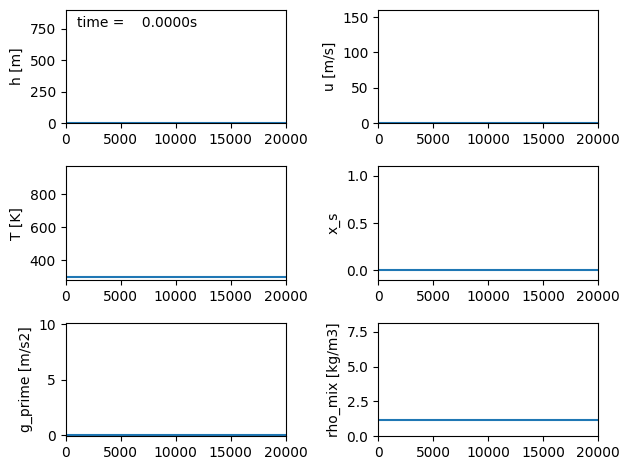

In [25]:
# create a figure for the plot
fig, axs = plt.subplots(3,2)

axs[0,0].set_xlim([x_left,x_right])
axs[0,1].set_xlim([x_left,x_right])
axs[1,0].set_xlim([x_left,x_right])
axs[1,1].set_xlim([x_left,x_right])
axs[2,0].set_xlim([x_left,x_right])
axs[2,1].set_xlim([x_left,x_right])

axs[0,0].set_ylabel('h [m]')
axs[0,1].set_ylabel('u [m/s]')
axs[1,0].set_ylabel('T [K]')
axs[1,1].set_ylabel('x_s')
axs[2,0].set_ylabel('g_prime [m/s2]')
axs[2,1].set_ylabel('rho_mix [kg/m3]')

axs[0,0].set_ylim(-0.1, hL*3.0)
axs[0,1].set_ylim(-0.1, uL*2.0)
axs[1,0].set_ylim(T_atm-20, TL+20)
axs[1,1].set_ylim(-0.1, 1.1)
axs[2,0].set_ylim(-0.1, 10.1)
axs[2,1].set_ylim(0.0, rhoL*1.1)

# this command increase the space between subplots
fig.tight_layout()

# plot the initial solution and call "line" the plot
line0, = axs[0,0].plot(x, qp[0,:],'-')
time_text = axs[0,0].text(0.05*(x_right-x_left), 0.85*hL*3.0, 'time ='+"{:10.4f}".format(0.0)+'s')

# plot the initial solution and call "line" the plot
line1, = axs[0,1].plot(x, qp[1,:],'-')

# plot the initial solution and call "line" the plot
line2, = axs[1,0].plot(x, qp[2,:],'-')

# plot the initial solution and call "line" the plot
line3, = axs[1,1].plot(x, qp[3,:],'-')

# plot the initial solution and call "line" the plot
line4, = axs[2,0].plot(x, gp[:],'-')

# plot the initial solution and call "line" the plot
line5, = axs[2,1].plot(x, rhom[:],'-')

line = [line0, line1, line2, line3, line4, line5]

We want to plot an animation of the solution and we use the matplotlib function *animatation*. It requires to initialize the objects that we want to update at each iteration with a function that we will call *init*.

In this case, we want to update the line plot and a text box with the current time of the solution.

In [26]:
def init():
    line[0].set_data(x, qp[0,:])
    line[1].set_data(x, qp[1,:])
    line[2].set_data(x, qp[2,:])
    line[3].set_data(x, qp[3,:])
    line[4].set_data(x, gp[:])
    line[5].set_data(x, rhom[:])
    time_text.set_text('time ='+"{:10.4f}".format(0.0)+'s')
    return line, time_text

The matplotlit function *animation* also need a function updating the solution. We define the *animate* function, which takes as input the index $n$ of the frame (time step) to plot.

This function is iterated and for each time step it computes the new solution array $q$.

With a nonlinear problem, the characteristic speeds change with the solution, and thus the time step given by the CFL condition. For this reason, we need to compute the time step inside the *animate* function.

In addition, when we use a linear reconstruction, the characteristic speeds should be computed for the values reconstructed at the interfaces.

Beacuse the time step change with the solution, we do not know in advance how many iteration we need to reach the final time. For this reason, we add a check inside the *animate* function, with a call to the function *event_source.stop()*:

    if ( t > t_final):
        ani_new.event_source.stop()
    

In [27]:
def animate(n,flux_func):

    global q,u,dx,dt,t,t_final
    global any_new

    if (n==1):

        time.sleep(5)

    q_old = q

    # update the solution in the first point with the periodic boundary condition
    q_intL,q_intR = recontruct_interfaces(q,dx,'minmod');

    # maximum time step for the characteristic speeds from the
    # variables reconstructed at the left of the interfaces
    dtL = eval_dt(q_intL,Courant_No,dx)

    # maximum time step for the characteristic speeds from the
    # variables reconstructed at the right of the interfaces
    dtR = eval_dt(q_intR,Courant_No,dx)

    # we take the minimum between the two time steps
    dt = np.minimum(dtL,dtR)

    q_temp = advance_finite_volume(q_old,dx,dt,flux_func)
    q = advance_source_term(q_temp,dt)

    t = t+dt
    # print('time ='+str(t)+'s ','dt ='+str(dt)+'s')
    for i in range(n_cells):

        qp[:,i],rhom[i],Cv,gp[i] = eval_phys(q[:,i])

    # update the plotted data
    line[0].set_data(x, qp[0,:])
    line[1].set_data(x, qp[1,:])
    line[2].set_data(x, qp[2,:])
    line[3].set_data(x, qp[3,:])
    line[4].set_data(x, gp[:])
    line[5].set_data(x, rhom[:])

    time_text.set_text('time ='+"{:10.4f}".format(t)+'s')
    if ( t > t_final):
        ani_new.event_source.stop()

    return line, time_text

We can see here that at the end of the list of arguments of the function *animation.FuncAnimation*, there is a list

    fargs=(advance_expl_central,)
    
This list contains the additional arguments to pass to *animate_new*.

In this way, we don't need to specify inside the function *animate_new* the scheme to use to update the numerical solution, but we can use *animate_new* for both the central and backward schemes.

**N.B.** It is important to know if condition at the inlet is a subcritical or supercritical condition, i.e. if the two characteristic speeds have the same sign. For this reason, we compute and print the two eigenvalues of the Jacobian of the flux computed with the inlet conditions for $h$ and $u$.


In [31]:
# Define the time step dt
global t,dt

t = 0.0

Courant_No = 0.49
# Define the time step dt
q_old = q

time_steps = 100

global ani_new

anim = animation.FuncAnimation(fig, animate, np.arange(1,time_steps+1), init_func=init,
     interval=100,blit=False,fargs=(num_flux_KT,),repeat=False)


In [29]:
from matplotlib import rc
rc('animation', html='jshtml')

In [32]:
anim